# Setup

In [1]:
# Generic
import copy
import typing
from pathlib import Path
import html

# Plotting
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch
# Utilities
from muutils.statcounter import StatCounter

# Our Code
from muutils.nbutils.configure_notebook import configure_notebook
from maze_dataset.plotting import MazePlot
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.training.config import ZanjHookedTransformer
from maze_transformer.evaluation.eval_model import predict_maze_paths, evaluate_model
from maze_transformer.evaluation.baseline_models import RandomBaseline
from muutils.mlutils import get_checkpoint_paths_for_run
from maze_transformer.evaluation.plotting import plot_predicted_paths, eval_model_at_checkpoints, plot_pathdist_scores

In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

set up plots with PLOT_MODE = 'inline', FIG_OUTPUT_FMT = None, FIG_BASEPATH = None
DEVICE = device(type='cpu')


In [5]:
# Setup
PATH_EXAMPLES: Path = Path("../examples/")
PATH_DATA: Path = Path("../data/")

# We won't be training any models
torch.set_grad_enabled(False)

# get the default model from examples
MODEL_PATH: Path = PATH_EXAMPLES / "multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj"
# MODEL_PATH: Path = PATH_DATA / "custom_2023-05-24-05-03-04/model.final.zanj"
# MODEL_PATH: Path = PATH_EXAMPLES / "hallway-medium_2023-06-16-03-40-47.iter_26554.zanj"
print(f"will try to get model from {MODEL_PATH.as_posix()}")
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
print(f"loaded model: {MODEL.config.name} with {MODEL.num_params()} parameters")

will try to get model from ../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
self.tokenization_mode = <TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
loaded model: multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1 with 70319 parameters


In [6]:
# generate a smaller test dataset from the same config
DATASET_TEST_CFG: MazeDatasetConfig = copy.deepcopy(MODEL.config.dataset_cfg)
DATASET_TEST_CFG.n_mazes = 100
DATASET_TEST: MazeDataset = MazeDataset.from_config(
    DATASET_TEST_CFG,
    local_base_path=PATH_DATA,
    verbose=True,
)
print(f"got test dataset: {DATASET_TEST.cfg.name} with {len(DATASET_TEST)} mazes")

trying to get the dataset 'demo-g6-n100-a_dfs-h10871'
seeing if we can download the dataset...
no download found, or download failed
generating dataset...


generating & solving mazes: 100%|██████████| 100/100 [00:01<00:00, 63.35maze/s]


saving dataset to ..\data\demo-g6-n100-a_dfs-h10871.zanj
Got dataset demo with 100 items. output.cfg.to_fname() = 'demo-g6-n100-a_dfs-h10871'
got test dataset: demo with 100 mazes


# plot example mazes

Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Gettin

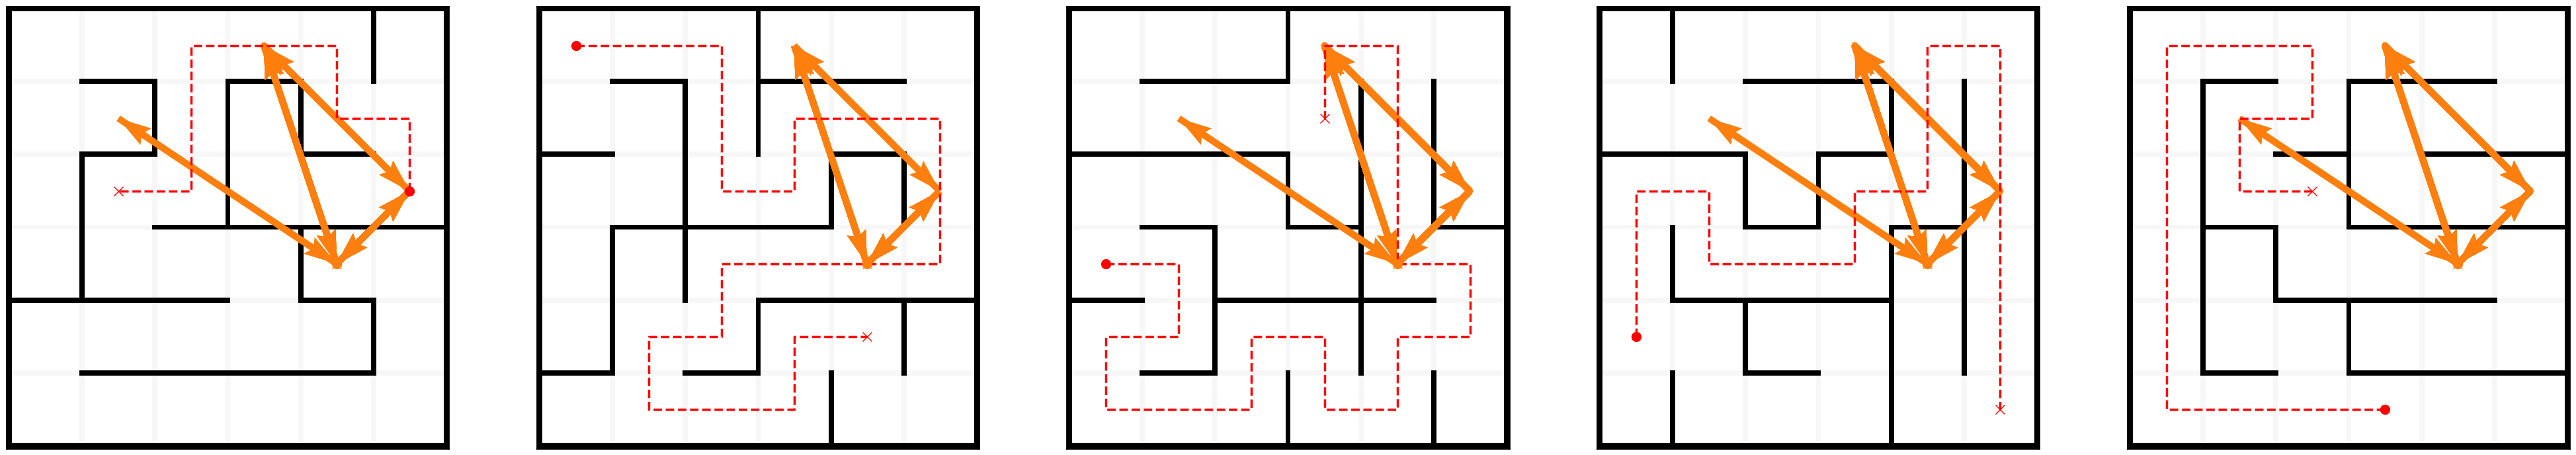

(<Figure size 5000x1000 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

In [7]:
plot_predicted_paths(MODEL, DATASET_TEST, n_mazes=5, max_new_tokens=50)

Getting vocab
Getting vocab
Getting vocab


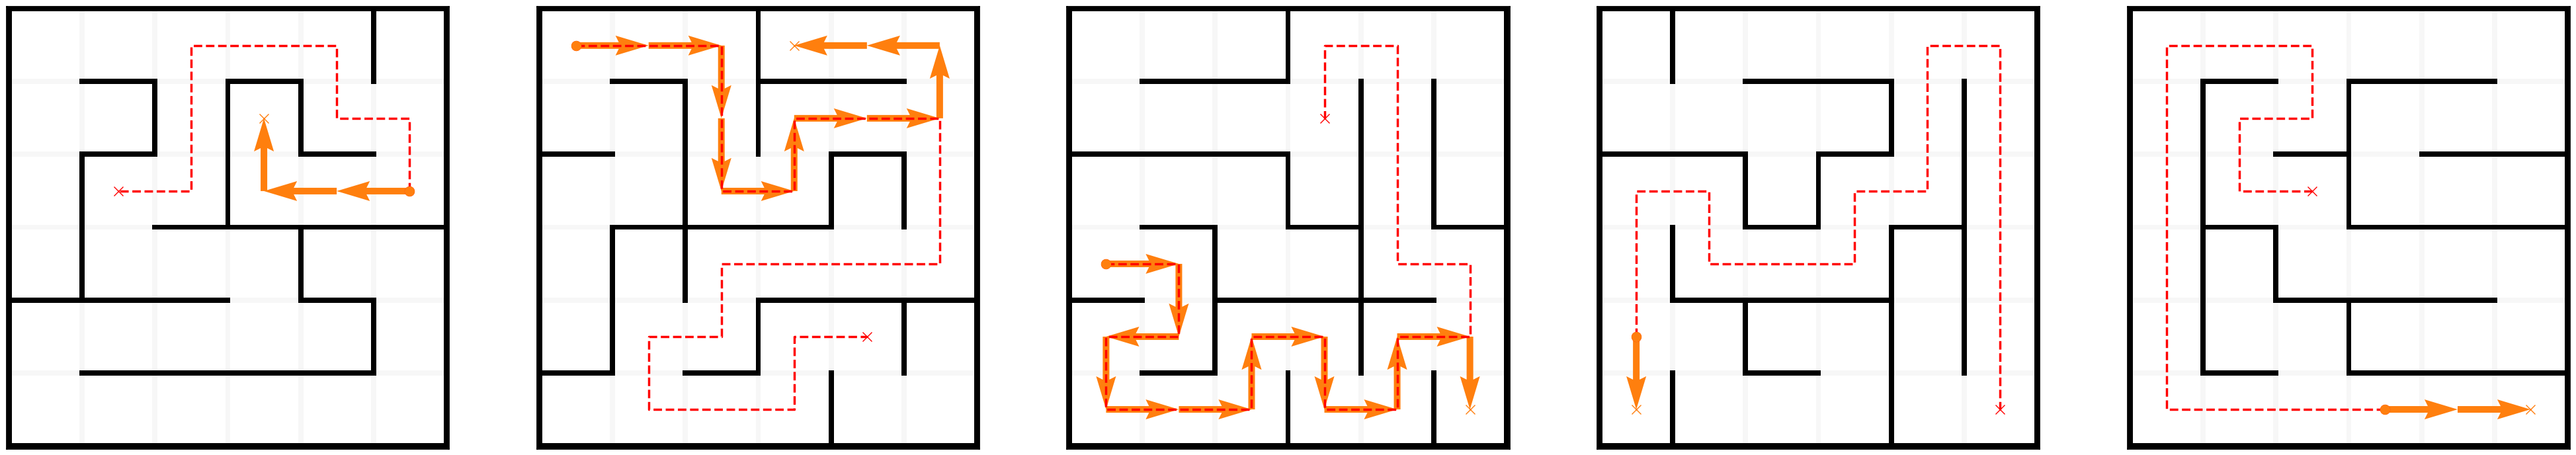

(<Figure size 5000x1000 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

In [8]:
# now let's do the same with the baseline solver
BASELINE_SOLVER: RandomBaseline = RandomBaseline(MODEL.zanj_model_config)
plot_predicted_paths(BASELINE_SOLVER, DATASET_TEST, n_mazes=5, max_new_tokens=15)

# run path dist eval

In [9]:
PATHDIST_SCORES: dict[str, dict[int, StatCounter]] = eval_model_at_checkpoints(MODEL_PATH, DATASET_TEST, max_checkpoints=5)

Found 2 checkpoints, min_index=0, max_index=78
will evaluate 2 checkpoints: [(0, '../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/checkpoints/model.iter_0.zanj'), (78, '../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/checkpoints/model.iter_78.zanj')]
# Evaluating checkpoint 0 at ..\examples\multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02\checkpoints\model.iter_0.zanj
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getti

C:\Users\Aaron\Desktop\NTFS\NTFS_Storage\dev\Unsearch\m-t_dev\maze-transformer\maze_transformer\evaluation\path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[0, 3]])



Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Getting vocab
Gettin

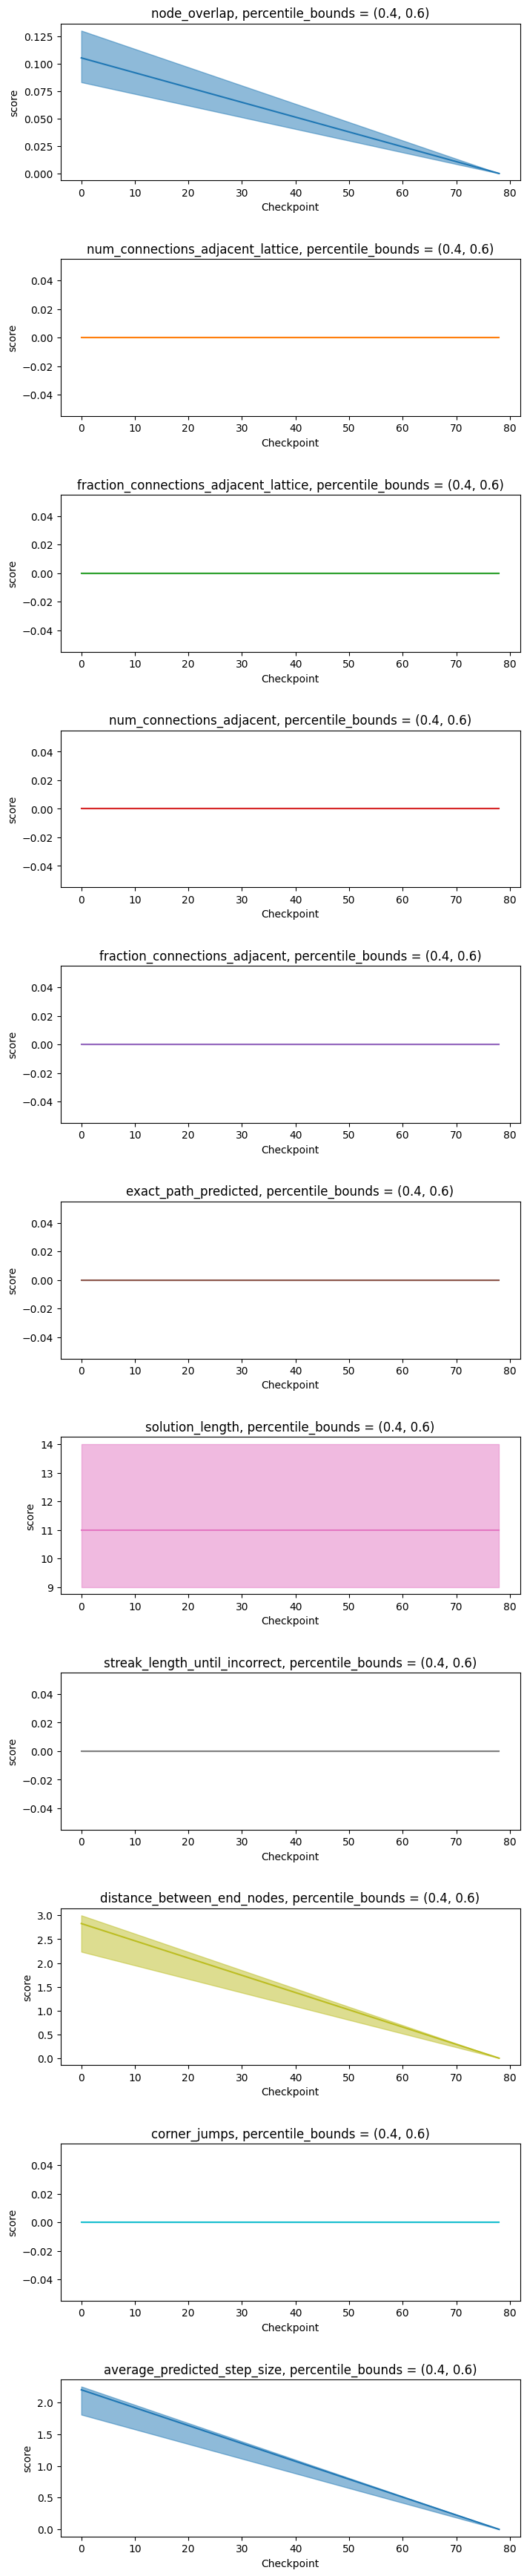

In [10]:
plot_pathdist_scores(PATHDIST_SCORES)